##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



Imports the drive module from the google.colab package.

Mounts the Google Drive into the Colab environment by calling the drive.mount('/content/drive') function. This step is necessary to access files and directories stored in your Google Drive from within the Colab environment.

Changes the current working directory (%cd) to a specific path within the mounted Google Drive. The path is '/content/drive/MyDrive/NERF_PROJECT'. This means that any subsequent file operations or code executed in the Colab environment will be performed in the 'NERF_PROJECT' directory within your Google Drive.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/NERF_PROJECT'

In [ ]:
!pip install transformers

In [ ]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import tqdm as td

import torch
import numpy as np
from PIL import Image
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

It uses the PyTorch library and appears to be setting up a deep learning model for depth estimation. Here's a breakdown of what each line of code does:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu"): This line checks if a CUDA-compatible GPU is available. If a GPU is available, it sets the device variable to use "cuda" (GPU); otherwise, it sets it to "cpu" (central processing unit). This is a common practice to make use of GPU acceleration if available, as it can significantly speed up deep learning computations.

depth_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device): This line initializes a deep learning model for depth estimation. It appears to be using a pre-trained model called "Intel/dpt-large." The model is loaded using the from_pretrained method, and then it's moved to the specified device (either "cuda" if a GPU is available or "cpu").

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large"): This line initializes a feature extractor model, which is also pre-trained on the "Intel/dpt-large" dataset. Feature extractors are often used in conjunction with other models to extract useful features from input data. In this case, it seems to be used in tandem with the depth estimation model for some task.

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
depth_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(



process_image(image): This function takes an input image as a NumPy array and performs the following steps:

Converts the image values to the uint8 data type after scaling them by 255. This step is to ensure that the image values are in the range [0, 255].
Converts the image to the RGB color format using the Pillow (PIL) library's convert method.
Passes the image through a pre-initialized feature extractor (feature_extractor) and converts the result to the PyTorch format (encoding) while ensuring it's on the specified device (either GPU or CPU).
Makes a depth prediction using the pre-trained depth estimation model (depth_model) and extracts the predicted depth values.
Interpolates the predicted depth values to match the size of the original image using bicubic interpolation.
Converts the interpolated depth map to a NumPy array, scales it to the [0, 255] range, and converts it to uint8 data type before returning it.
process_images(images): This function takes a list of input images and processes each image using the process_image function. It stores the resulting depth maps in a list and returns them as a NumPy array.

In [ ]:
def process_image(image):
    # Convert the image to the format expected by the feature extractor
    image = Image.fromarray((image * 255).astype('uint8'))
    image = image.convert("RGB")
    encoding = feature_extractor(image, return_tensors="pt").to(device)

    # Use the depth model to predict the depth map
    with torch.no_grad():
        outputs = depth_model(**encoding)
        predicted_depth = outputs.predicted_depth

    # Move the prediction tensor to the CPU and resize
    prediction_cpu = predicted_depth.cpu()
    prediction = torch.nn.functional.interpolate(
        prediction_cpu.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    # Normalize the depth map to [0, 1] and duplicate values across three channels
    normalized_depth = (prediction / torch.max(prediction)).numpy()
    formatted = np.stack([normalized_depth] * 3, axis=-1)

    return formatted




def process_images(images):
    depth_maps = []
    for image in td.tqdm(images):
        depth_maps.append(process_image(image))

    return np.array(depth_maps)


# Load Input Images and Poses


data = np.load('tiny_nerf_data.npz'): This line loads data from the 'tiny_nerf_data.npz' file into a variable called 'data'. The NPZ format is commonly used to store multiple NumPy arrays in a single file.

images = data['images']: This line extracts an array called 'images' from the loaded data. These are likely images, possibly used as inputs to a neural network or for some other image processing task.

poses = data['poses']: This line extracts an array called 'poses' from the loaded data. 'Poses' typically refer to the camera positions or transformations associated with each image. They are often used in 3D reconstruction or computer vision tasks.

focal = data['focal']: This line extracts a value called 'focal' from the loaded data. 'Focal' likely represents the focal length of the camera used to capture the images. It's a crucial parameter in 3D reconstruction tasks.

H, W = images.shape[1:3]: This line retrieves the height (H) and width (W) of the images by accessing the shape of the 'images' array. It assumes that the images are 2D arrays with shape (number of images, height, width, channels).

print(images.shape, poses.shape, focal): This line prints the shapes of the 'images' and 'poses' arrays, as well as the 'focal' value. It helps you understand the dimensions of the data you're working with.

testimg, testpose = images[101], poses[101]: This line extracts a specific image ('testimg') and its associated pose ('testpose') from the 'images' and 'poses' arrays at index 101. This might be done for testing or visualization purposes.

images = images[:100,...,:3]: This line selects the first 100 images from the 'images' array and keeps only the first three color channels (assuming the images are in RGB format). It essentially reduces the dataset to the first 100 images while removing the alpha channel if present.

poses = poses[:100]: This line selects the first 100 poses from the 'poses' array, aligning with the reduced 'images' dataset.

plt.imshow(testimg): This line uses the Matplotlib library to display the 'testimg' (the 101st image) as an image.

plt.show(): This line displays the image in a Matplotlib window.

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


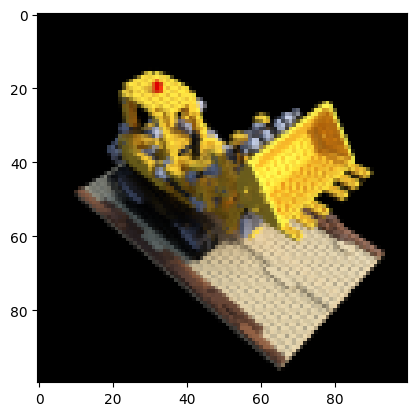

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

## Depth Images

depth_maps = process_images(images): This line calls the process_images function that was defined earlier. It processes a set of images stored in the images array to generate depth maps. The resulting depth maps are stored in the depth_maps variable.

sample = depth_maps[0]: This line selects the first depth map from the depth_maps array and stores it in the sample variable. It assumes that the depth_maps array contains generated depth maps.

plt.imshow(sample, cmap='gray'): This line uses Matplotlib to display the sample depth map as an image with a grayscale colormap. It visualizes the depth map as a grayscale image, where darker values typically represent objects closer to the camera, and lighter values represent objects farther away.

plt.show(): This line displays the depth map using Matplotlib, showing it in a separate window.

100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


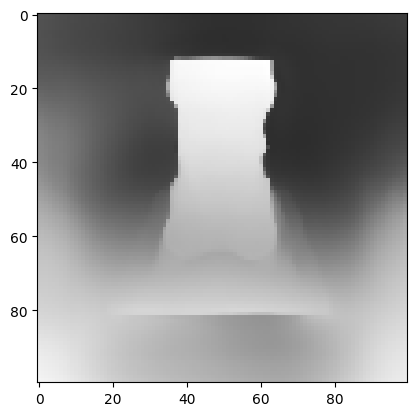

In [ ]:
depth_maps = process_images(images)
sample = depth_maps[0]
plt.imshow(sample, cmap='gray')
plt.show()

random_indices = np.random.choice(len(images), size=20, replace=False): This line generates an array of 20 random indices chosen from the range [0, len(images)), without replacement. In other words, it selects 20 unique random indices from the available images.

num_rows = 4 and num_cols = 5: These lines set the number of rows and columns for the grid of images. In this case, the grid will have 4 rows and 5 columns, accommodating a total of 20 images.

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10)): This line creates a grid of subplots (axes) with the specified number of rows and columns. It also sets the size of the figure to be displayed.

The following loop iterates through the subplots and populates them with randomly selected images:

random_index = random_indices[i]: This line retrieves a random index from the random_indices array for the current subplot iteration.
image = images[random_index]: It selects the image corresponding to the random index.
ax.imshow(image, cmap='gray'): This displays the selected image in the current subplot with a grayscale colormap.
ax.axis('off'): This turns off the axis labels for the current subplot to show just the image.
plt.subplots_adjust(wspace=0.2, hspace=0.3): This line adjusts the spacing between subplots within the grid, controlling the width (wspace) and height (hspace) between them.

plt.show(): Finally, this line displays the grid of images with randomly selected samples from the images array.



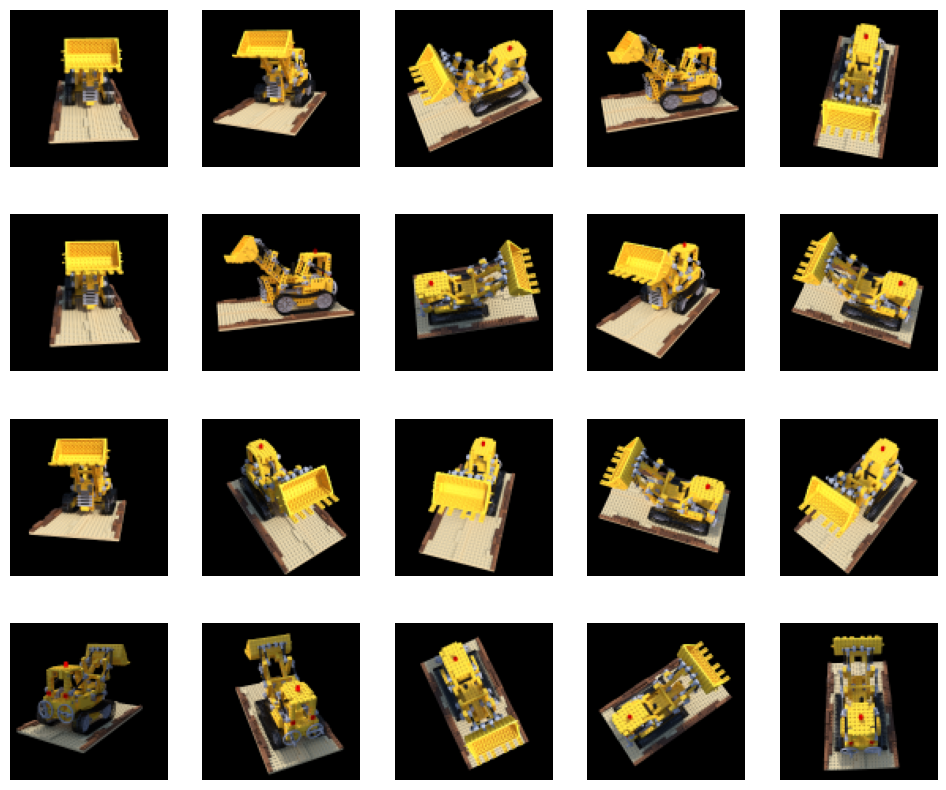

In [ ]:
random_indices = np.random.choice(len(images), size=20, replace=False)

num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    random_index = random_indices[i]
    image = images[random_index]

    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

random_indices = np.random.choice(len(images), size=20, replace=False): This line generates an array of 20 random indices chosen from the range [0, len(images)), without replacement. In other words, it selects 20 unique random indices from the available images.

num_rows = 4 and num_cols = 5: These lines set the number of rows and columns for the grid of images. In this case, the grid will have 4 rows and 5 columns, accommodating a total of 20 images.

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10)): This line creates a grid of subplots (axes) with the specified number of rows and columns. It also sets the size of the figure to be displayed.

The following loop iterates through the subplots and populates them with randomly selected images:

random_index = random_indices[i]: This line retrieves a random index from the random_indices array for the current subplot iteration.
image = images[random_index]: It selects the image corresponding to the random index.
ax.imshow(image, cmap='gray'): This displays the selected image in the current subplot with a grayscale colormap.
ax.axis('off'): This turns off the axis labels for the current subplot to show just the image.
plt.subplots_adjust(wspace=0.2, hspace=0.3): This line adjusts the spacing between subplots within the grid, controlling the width (wspace) and height (hspace) between them.

plt.show(): Finally, this line displays the grid of images with randomly selected samples from the images array.



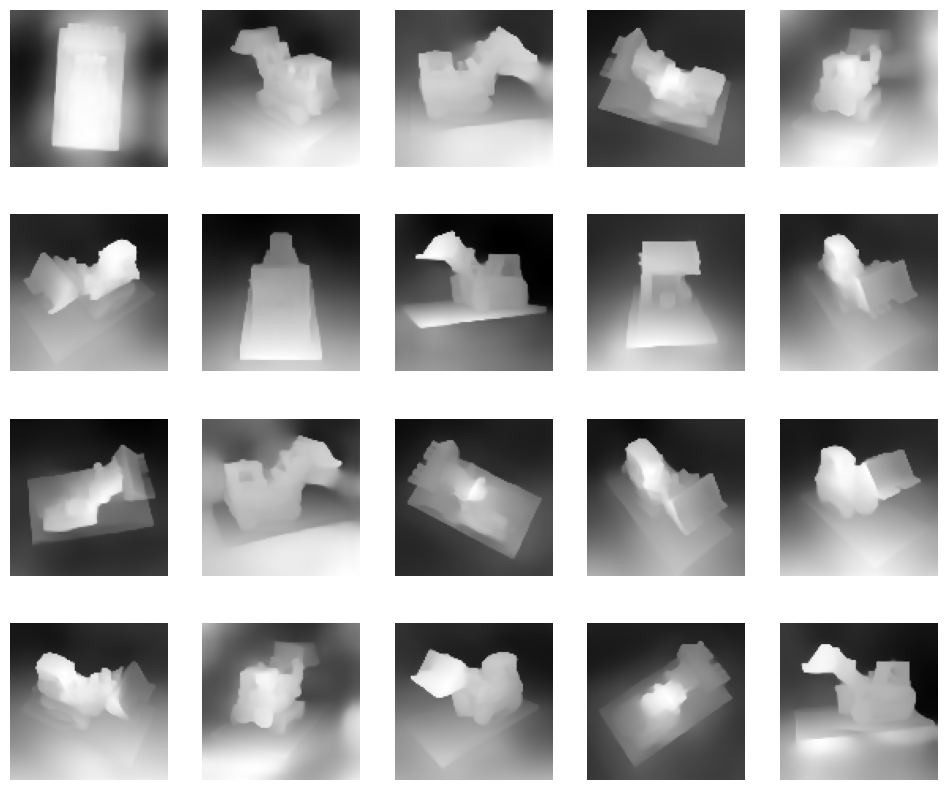

In [ ]:
random_indices = np.random.choice(len(depth_maps), size=20, replace=False)

num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    random_index = random_indices[i]
    image = depth_maps[random_index]

    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

# Optimize NeRF

posenc(x): This function is used for positional encoding. It takes a tensor x as input and performs sinusoidal encoding on it. The result is a concatenated tensor that includes the original tensor x and sine and cosine transformations of x at different frequencies.

L_embed: This variable specifies the number of positional encoding layers. In this code, it is set to 6, meaning that the positional encoding will be applied six times.

embed_fn: This variable is set to the posenc function, indicating that positional encoding will be used during the initialization of the model.

init_model(D=8, W=256, L_embed=6): This function initializes a neural network model. It takes three parameters: D for the number of dense layers, W for the number of neurons in each dense layer, and L_embed for the number of positional encoding layers. The model consists of dense layers with ReLU activation functions. It takes input with a shape of (3 + 3 * 2 * L_embed).

get_rays(H, W, focal, c2w): This function computes rays based on camera parameters. It takes the height (H), width (W), focal length (focal), and camera-to-world transformation matrix (c2w) as inputs. It generates rays in 3D space for each pixel in the image.

render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False): This function performs ray tracing or volume rendering. It takes several parameters, including a network function (network_fn) that likely represents a neural network model, rays origin (rays_o) and direction (rays_d), near and far clipping distances, the number of samples (N_samples), and an optional flag rand for random sampling along the rays. It returns rendered RGB maps, depth maps, and accumulation maps.



In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256, L_embed=6):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu: tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3 * 2 * L_embed))  # Update input shape for RGB-D
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i % 4 == 0 and i > 0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights[..., None] * z_vals[..., None], -2)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

## Training of model

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.08552652359008789 secs per iter


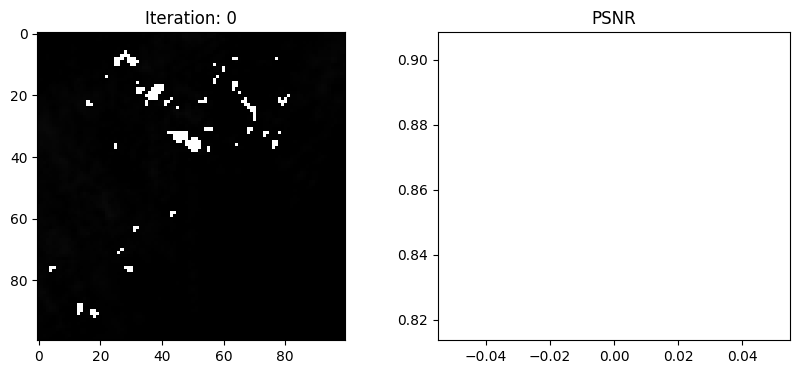

25 0.7234947109222412 secs per iter


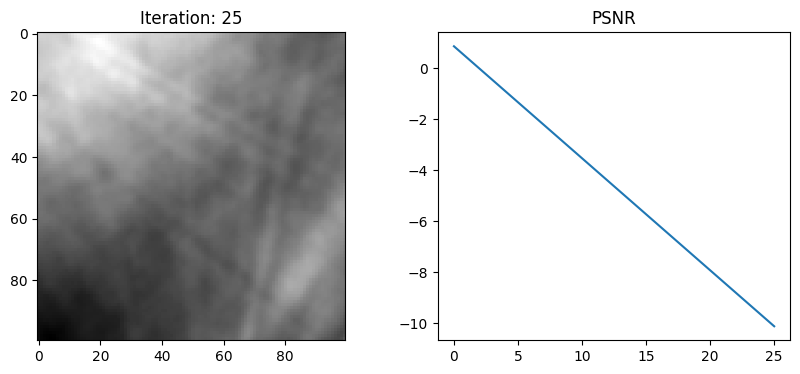

50 0.7435398578643799 secs per iter


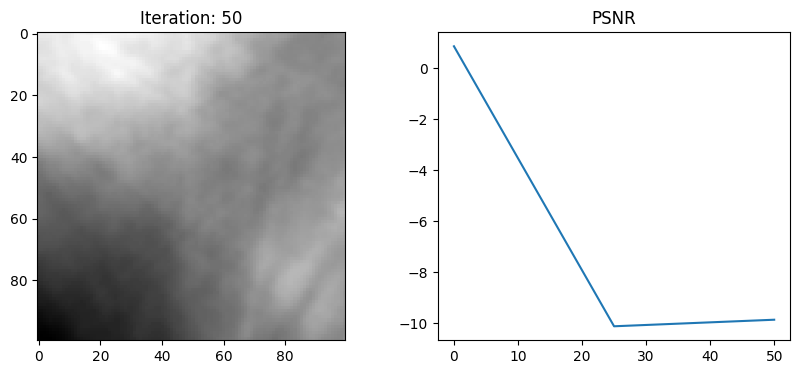

75 0.7254351902008057 secs per iter


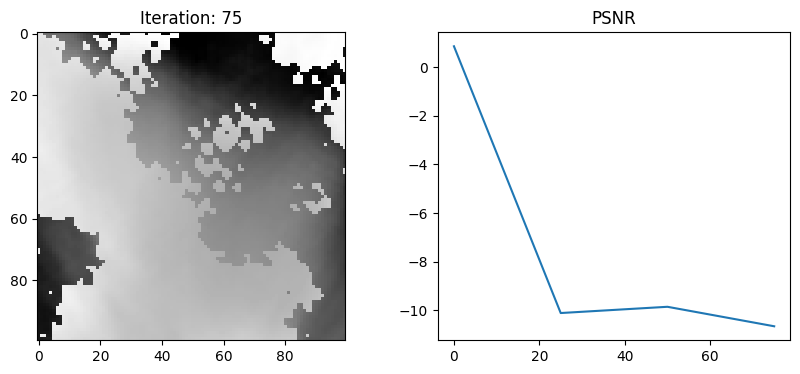

100 0.7318848705291748 secs per iter


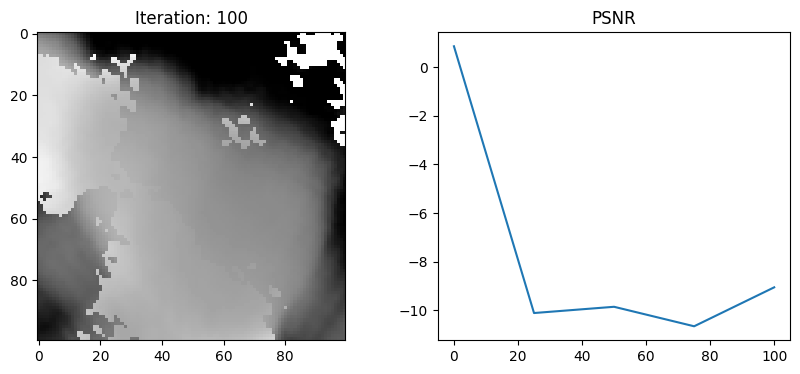

125 0.7829324436187745 secs per iter


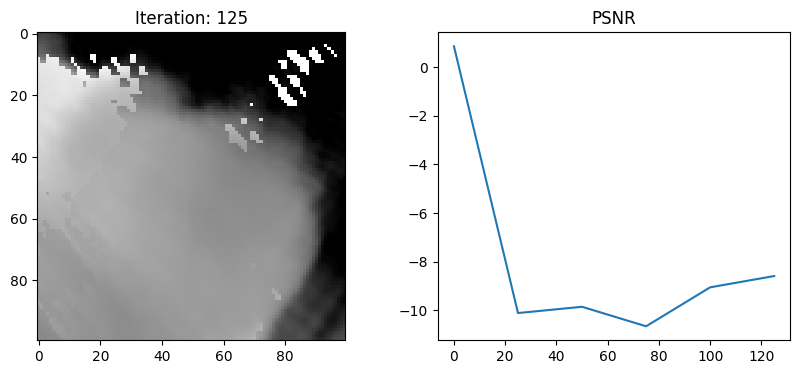

150 0.6995790672302246 secs per iter


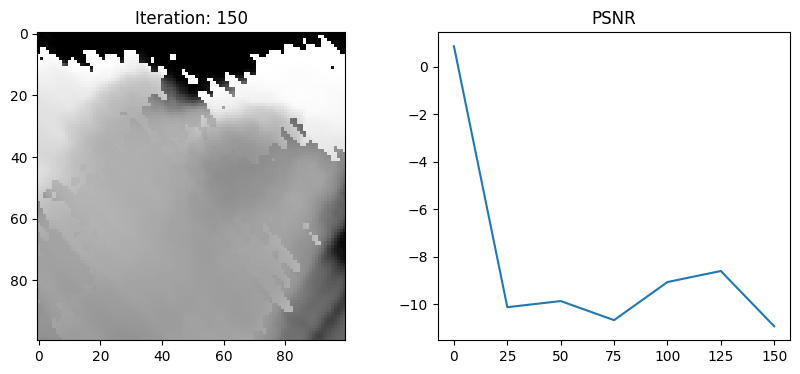

175 0.7011008071899414 secs per iter


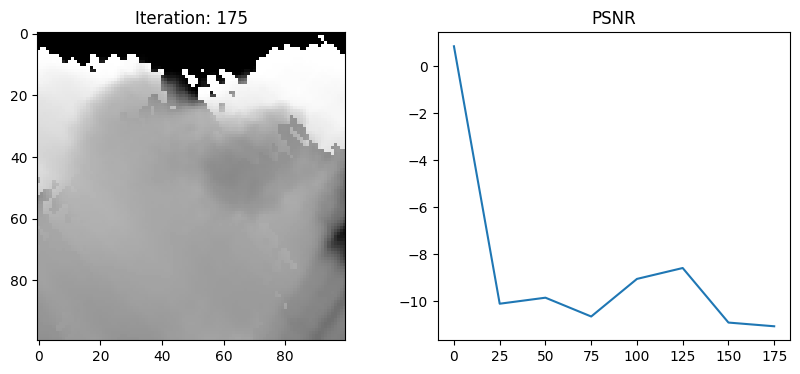

200 0.7031452369689941 secs per iter


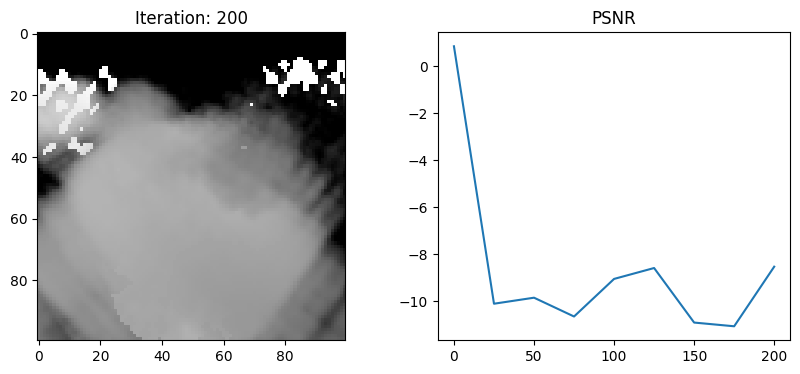

225 0.6952376937866211 secs per iter


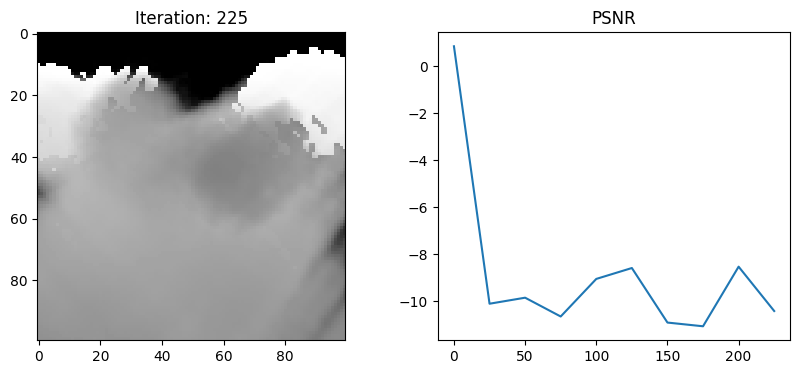

250 0.7095272254943847 secs per iter


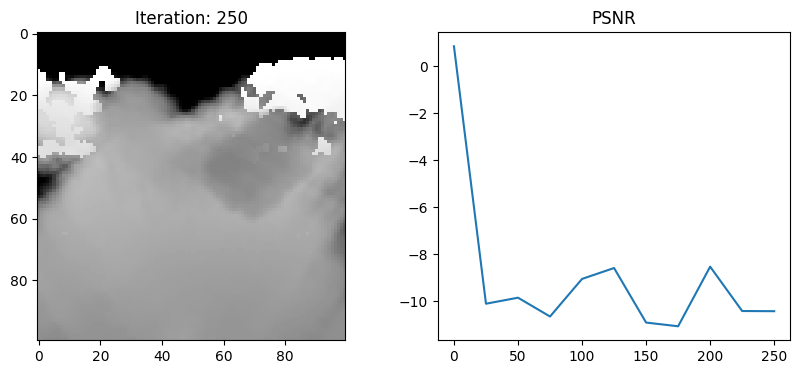

275 0.6911578273773193 secs per iter


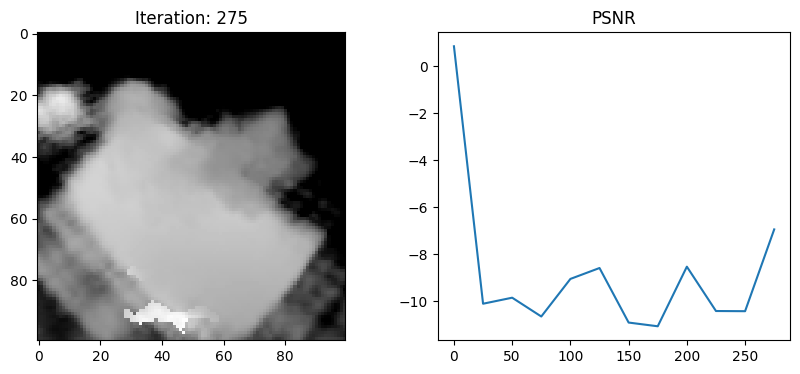

300 0.6914412784576416 secs per iter


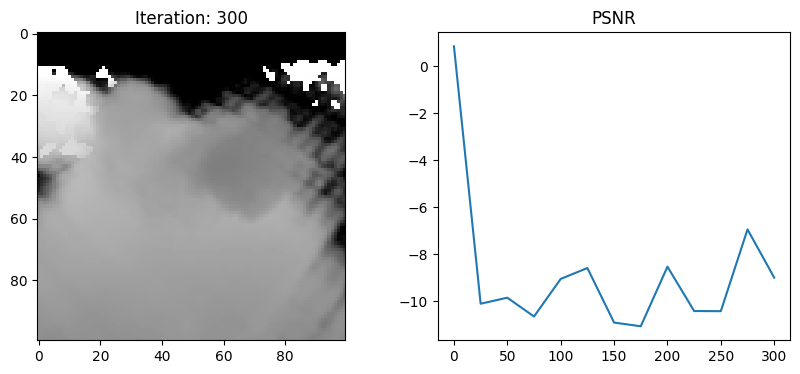

325 0.691168327331543 secs per iter


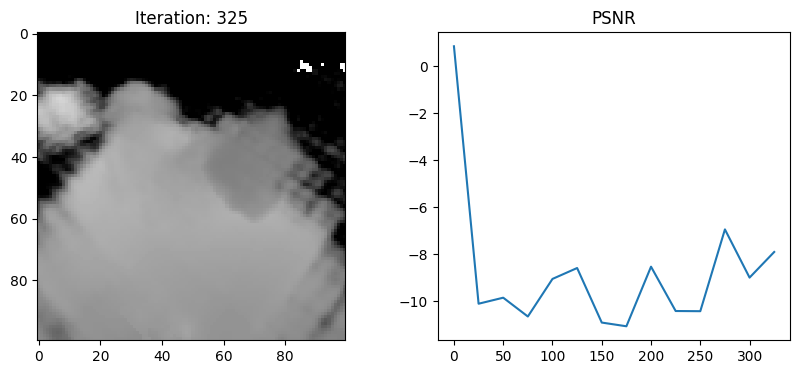

350 0.6898776340484619 secs per iter


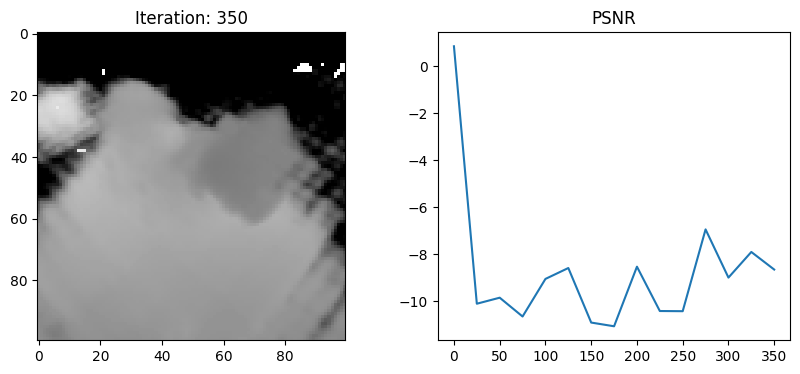

375 0.6968732261657715 secs per iter


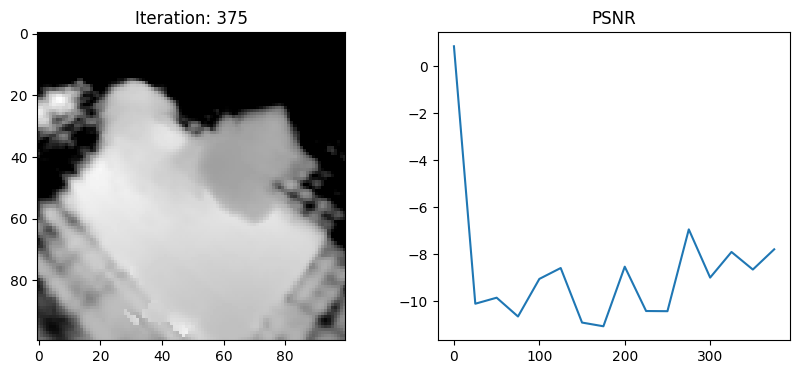

400 0.6869021701812744 secs per iter


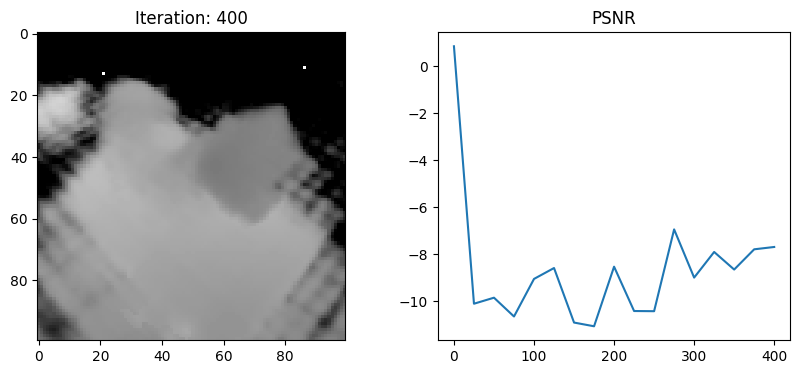

425 0.6859495544433594 secs per iter


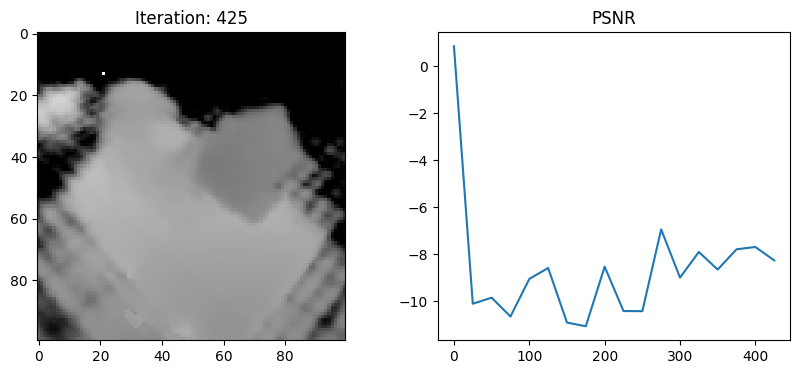

450 0.6879911136627197 secs per iter


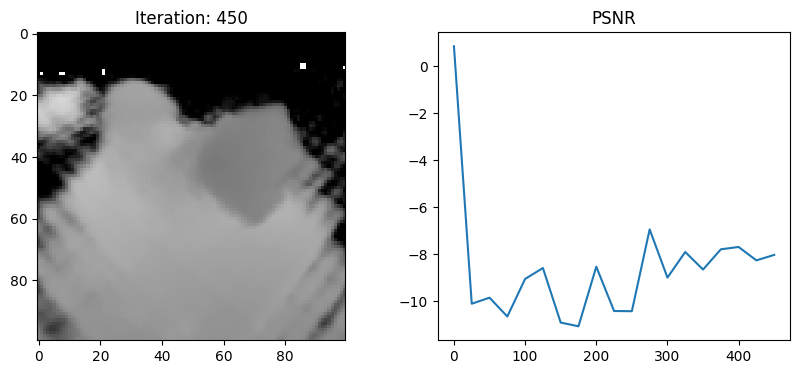

475 0.6880953788757325 secs per iter


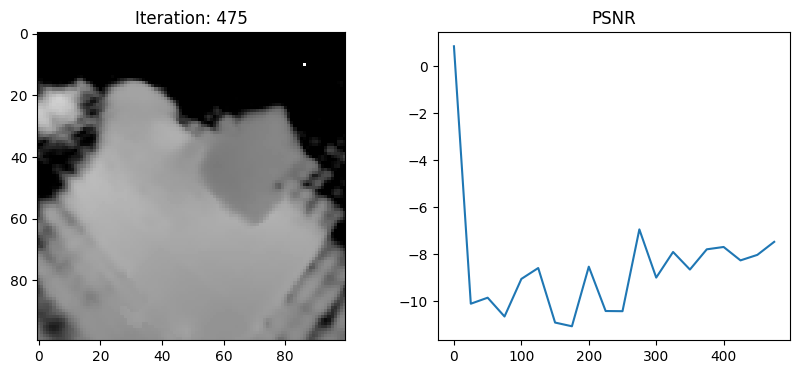

500 0.6879191303253174 secs per iter


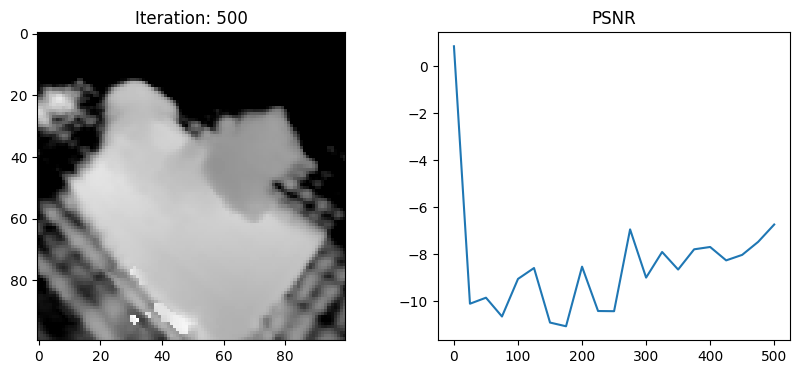

525 0.6863275337219238 secs per iter


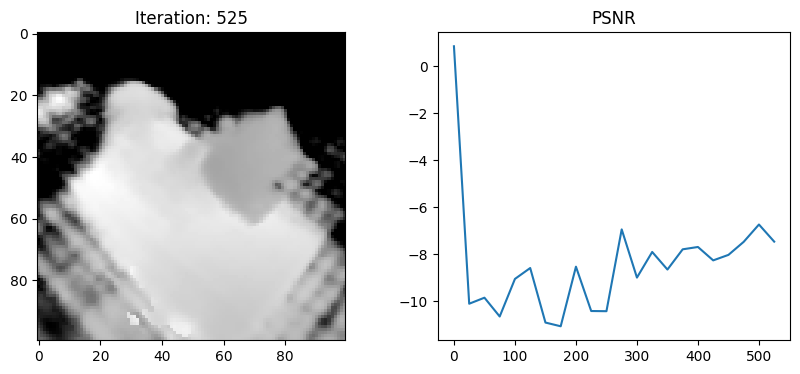

550 0.691751127243042 secs per iter


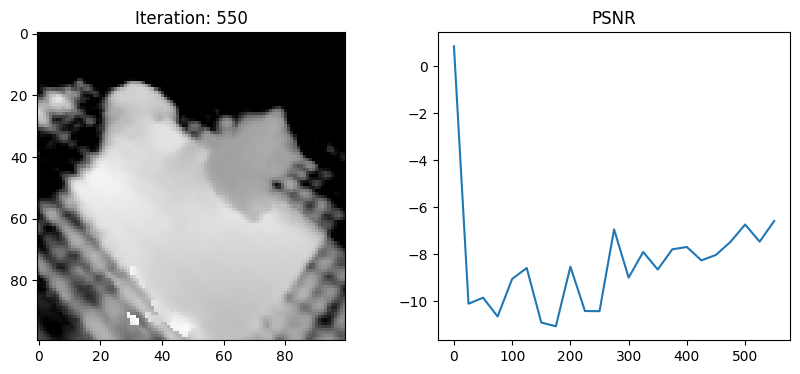

575 0.6870219993591309 secs per iter


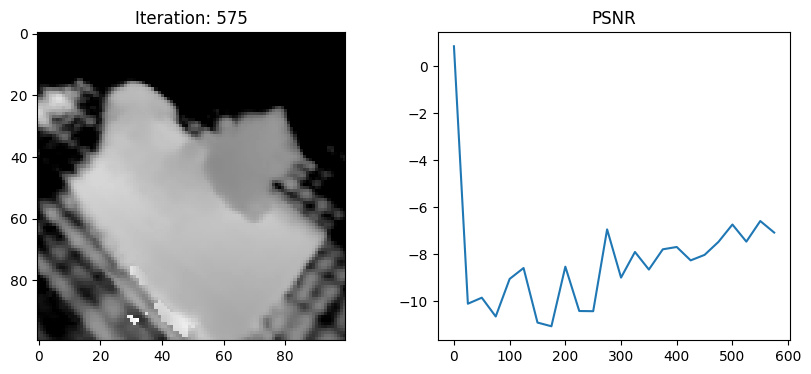

600 0.6858317279815673 secs per iter


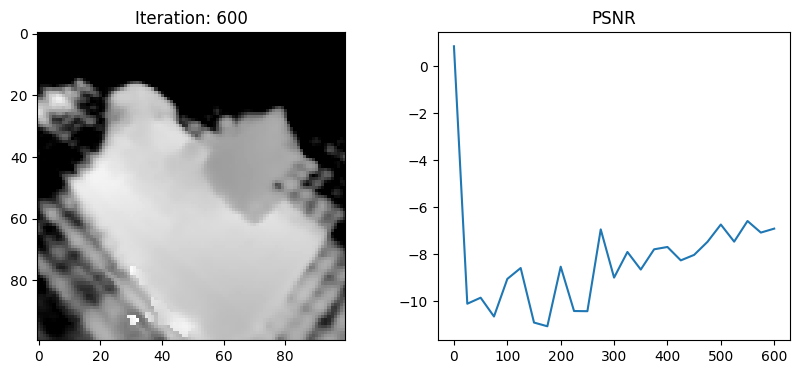

625 0.6874511337280274 secs per iter


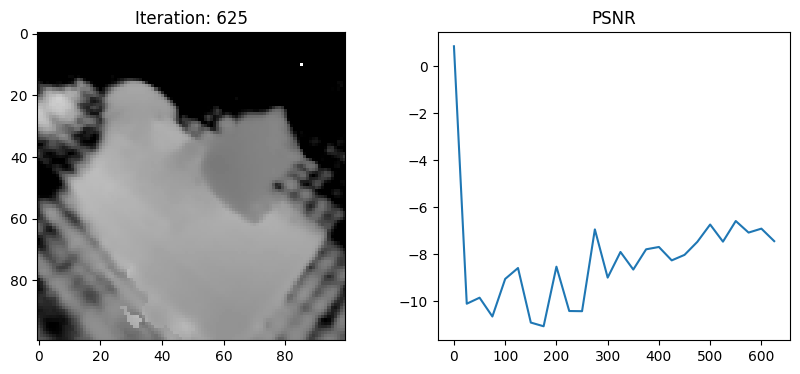

650 0.6917905521392822 secs per iter


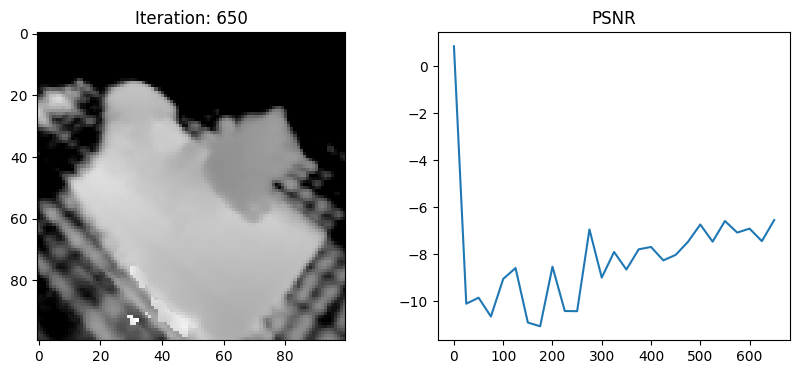

675 0.6869121646881103 secs per iter


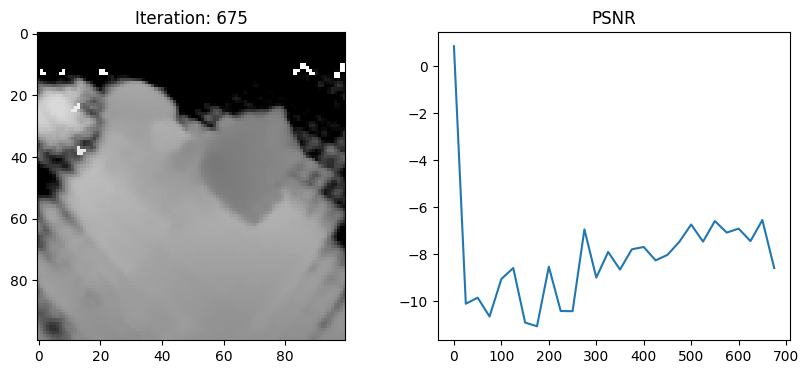

700 0.6875922679901123 secs per iter


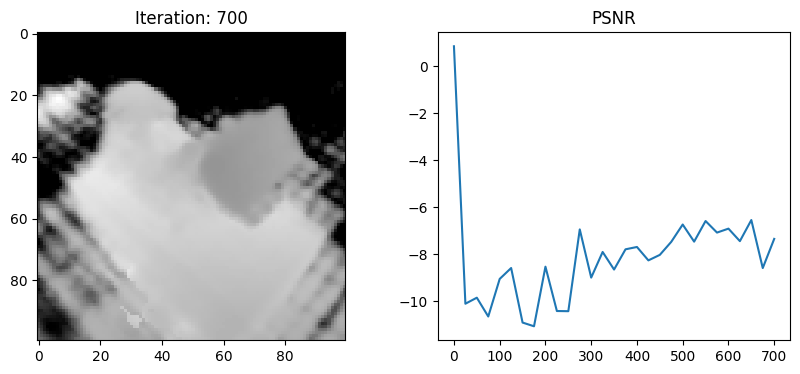

725 0.6949234485626221 secs per iter


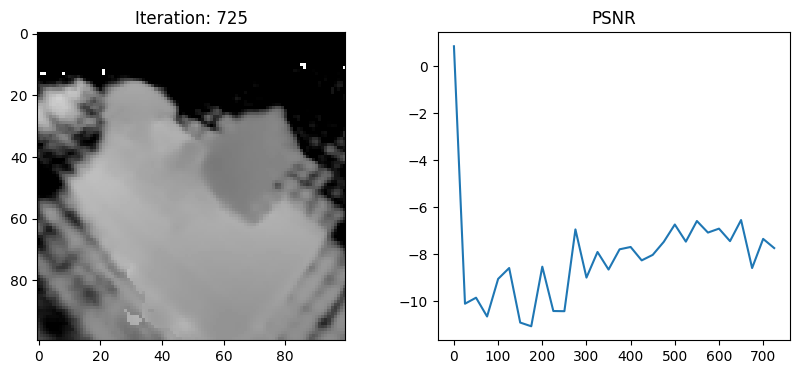

750 0.6859035587310791 secs per iter


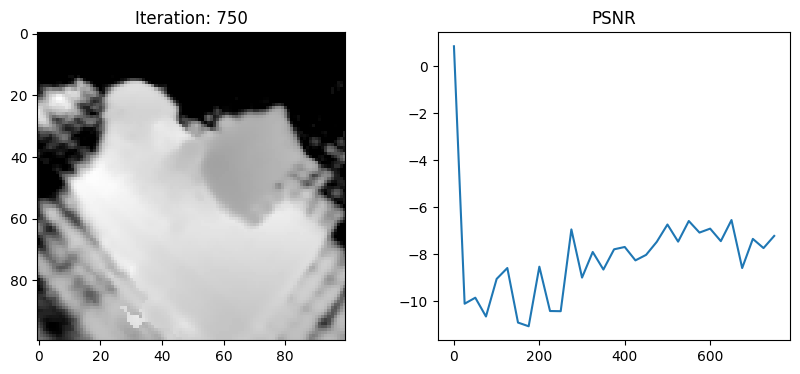

775 0.6976670932769775 secs per iter


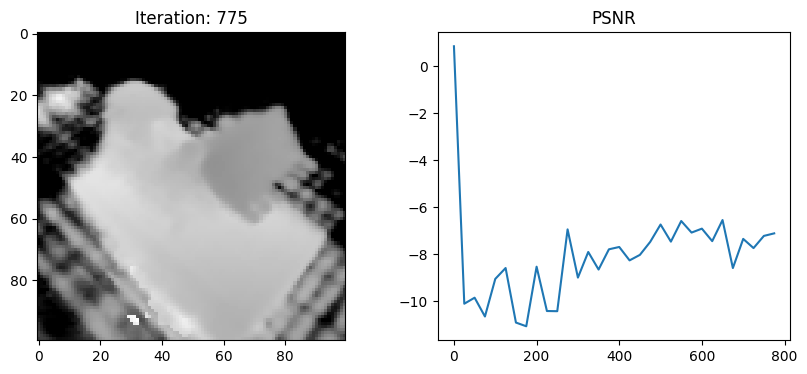

800 0.6854582500457763 secs per iter


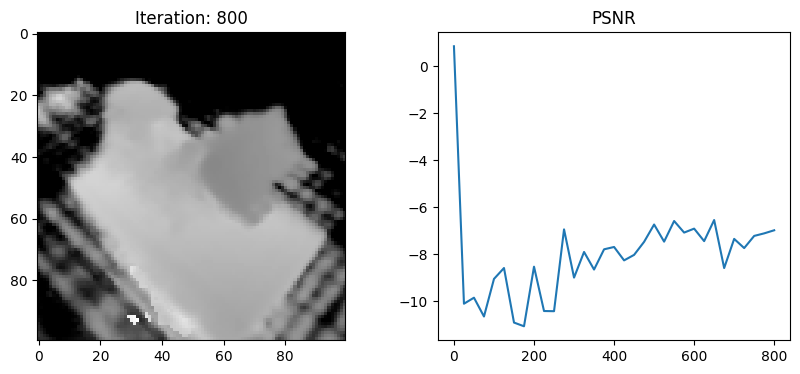

825 0.6920919990539551 secs per iter


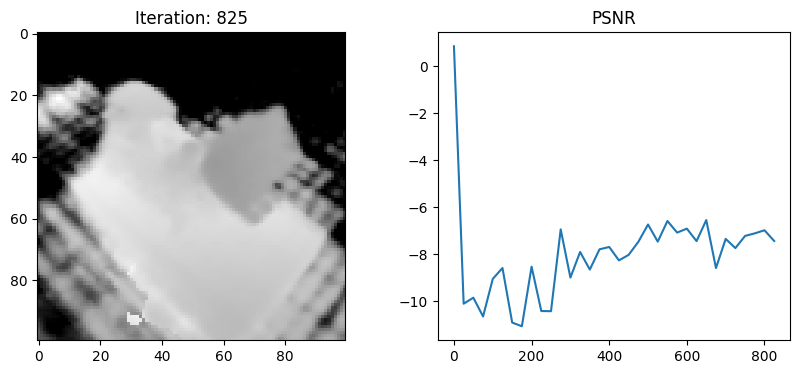

850 0.6861475181579589 secs per iter


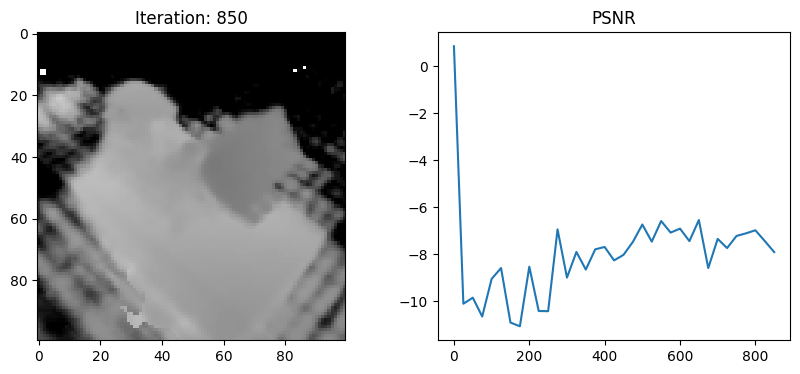

875 0.684806022644043 secs per iter


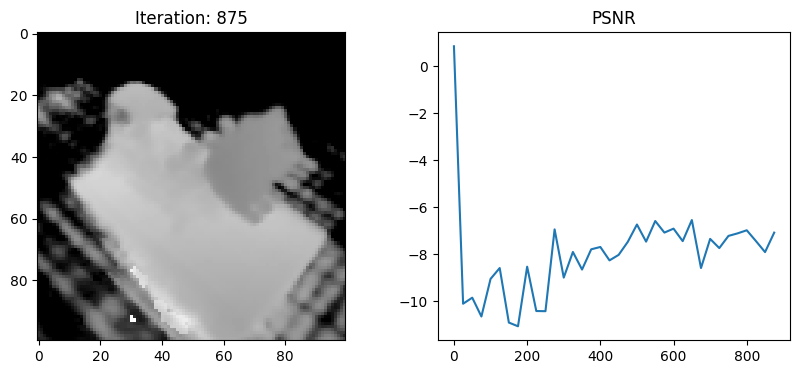

900 0.6856689453125 secs per iter


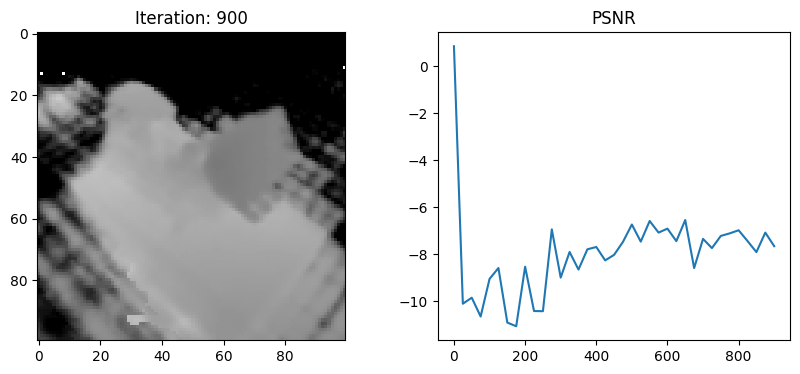

925 0.6885302448272705 secs per iter


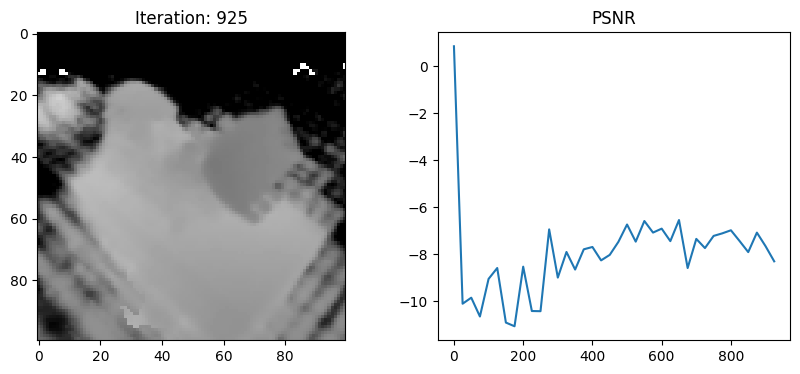

950 0.6843327140808105 secs per iter


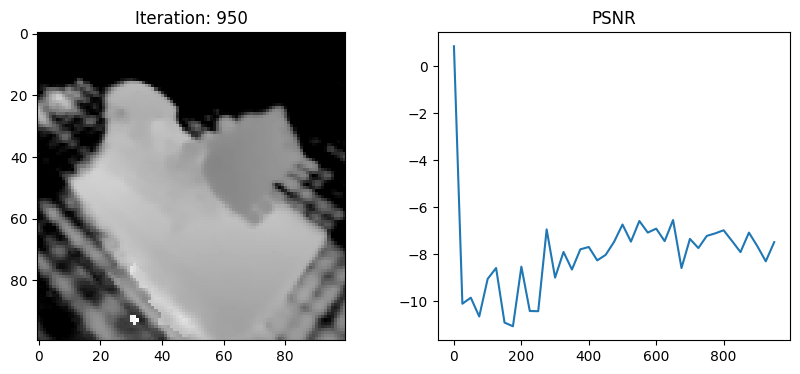

975 0.6848378658294678 secs per iter


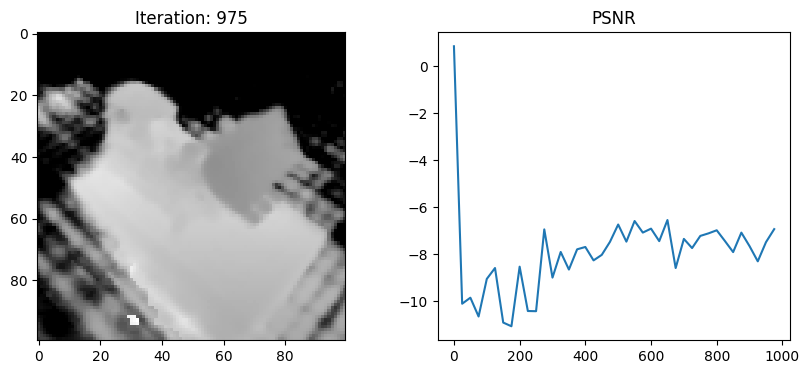

1000 0.6897511577606201 secs per iter


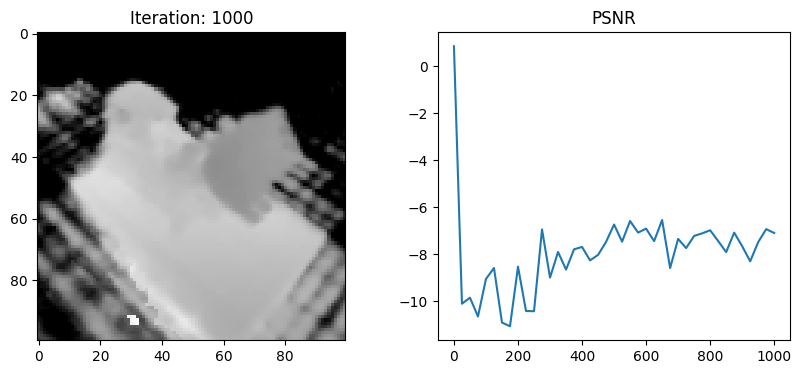

Initial Training Done


In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

model = init_model()
initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

N_samples = 64
N_iters_initial = 1000
psnrs = []
iternums = []
i_plot = 25

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

import time
t = time.time()

generated_depth_images = []

# Initial training loop
for i in range(N_iters_initial + 1):
    img_i = np.random.randint(images.shape[0])
    target_rgb = images[img_i]
    target_depth = depth_maps[img_i]  # Load your depth images here
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)

    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        rgb_loss = tf.reduce_mean(tf.square(rgb - target_rgb))
        depth_loss = tf.reduce_mean(tf.square(depth - target_depth))
        loss = rgb_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Append the generated depth image to the list
    generated_depth_images.append(depth.numpy())

    if i % i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Use a depth image from depth_maps for testing
        test_depth_index = np.random.randint(depth_maps.shape[0])
        test_depth = depth_maps[test_depth_index]
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        rgb_loss = tf.reduce_mean(tf.square(rgb - testimg))
        depth_loss = tf.reduce_mean(tf.square(depth - test_depth))
        loss = depth_loss
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(depth, cmap='gray')
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

# Save the checkpoint and generated depth images
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
checkpoint_manager.save()
# Save all depth images in a single .npz file
np.savez('generated_depth_images.npz', generated_depth_images=generated_depth_images)
print('Initial Training Done')


0 0.7756471920013428 secs per iter


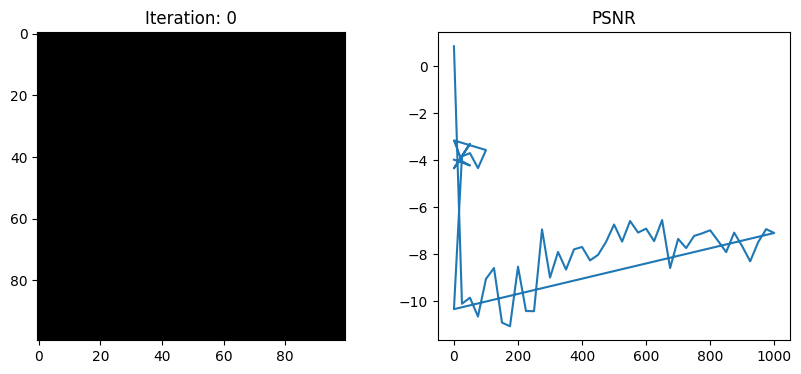

25 0.6623753070831299 secs per iter


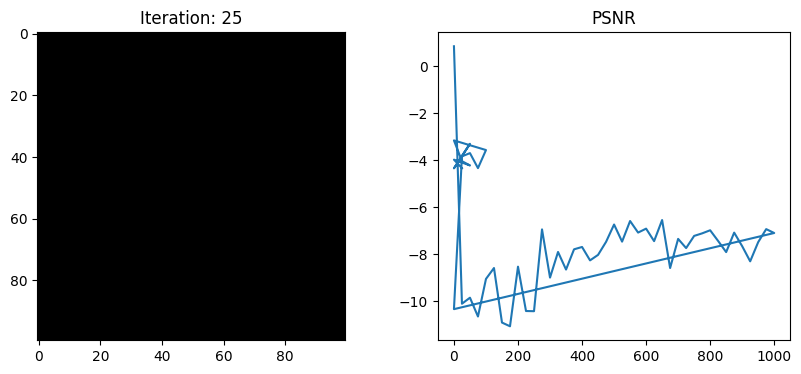

In [ ]:
# Final training loop
N_iters_final = 1000  # Adjust as needed
for i in range(N_iters_final + 1):
    img_i = np.random.randint(images.shape[0])
    target_rgb = images[img_i]
    target_depth = generated_depth_images[img_i]  # Use saved depth images for training
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)

    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        depth_loss = tf.reduce_mean(tf.square(depth - target_depth))
        loss = depth_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i % i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Use a depth image from depth_maps for testing
        test_depth_index = np.random.randint(generated_depth_images.shape[0])
        test_depth = generated_depth_images[test_depth_index]
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        rgb_loss = tf.reduce_mean(tf.square(rgb - testimg))
        depth_loss = tf.reduce_mean(tf.square(depth - test_depth))
        loss = depth_loss
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(depth, cmap='gray')
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

# Save the final checkpoint
checkpoint_manager.save()
print('Final Training Done')


In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(depth,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append(depth * 255)

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)